# Sensitivity Analysis & Symbolic Regression
**Description:** Use Sobol sensitivity analysis on diffusion parameters, then apply symbolic regression to derive empirical formulae relating parameters to pattern wavelengths.

**Sections:**
1. Imports & Setup
2. Define Feature Extraction
3. Sobol Analysis for Turing
4. Symbolic Regression for Turing Wavelength
5. Wavelength Correlation Buckling vs. Turing
6. Bar Chart of Sobol Indices
7. Save Models & Figures

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import sys, os
project_root = os.path.abspath("..") 
sys.path.insert(0, project_root)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import model
from SALib.sample import saltelli
from SALib.analyze import sobol
from pysr import PySRRegressor
from joblib import Parallel, delayed

In [15]:
# --- Turing metric: spatial variance (as proxy for "entropy") ---
def compute_entropy_metric(pattern):
    normalized = (pattern - np.mean(pattern)) / np.std(pattern)
    return np.var(normalized)

# --- Buckling metric: peak-to-peak displacement ---
def compute_buckling_metric(w):
    return np.ptp(w)

In [16]:
problem_turing = {
    'num_vars': 2,
    'names': ['Du', 'Dv'],
    'bounds': [[0.05, 0.3], [0.01, 0.1]]
}

N = 64
param_vals_turing = saltelli.sample(problem_turing, N, calc_second_order=False)

Nx = Ny = 64
dx = 1.0
u0 = np.ones((Nx, Ny)) + 0.02*np.random.randn(Nx, Ny)
v0 = np.zeros((Nx, Ny)) + 0.02*np.random.randn(Nx, Ny)
r = 8
u0[Nx//2 - r:Nx//2 + r, Ny//2 - r:Ny//2 + r] = 0.5
v0[Nx//2 - r:Nx//2 + r, Ny//2 - r:Ny//2 + r] = 0.25

Y_turing = np.empty(len(param_vals_turing))
for i, (Du, Dv) in enumerate(param_vals_turing):
    try:
        u_sim, v_sim = model.sim_turing(
            Du, Dv,
            lambda u,v: -u*v**2 + 0.04*(1-u),
            lambda u,v: u*v**2 - (0.04+0.06)*v,
            u0.copy(), v0.copy(),
            dx, 1.0, 500
        )
        Y_turing[i] = compute_entropy_metric(v_sim)
    except Exception:
        Y_turing[i] = np.nan

Y_turing = np.nan_to_num(Y_turing, nan=np.nanmean(Y_turing))
Si_turing = sobol.analyze(problem_turing, Y_turing, calc_second_order=False)

/var/folders/91/4mn89x6x6rs590bxz0qdh4zc0000gn/T/ipykernel_85152/859767083.py:8: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_vals_turing = saltelli.sample(problem_turing, N, calc_second_order=False)
/Users/jiachen/anaconda3/envs/course_proj/lib/python3.13/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


In [17]:
problem_buckling = {
    'num_vars': 3,
    'names': ['P', 'A', 'Q'],
    'bounds': [[500, 2000], [0.1, 0.5], [0.0, 0.05]]
}

N_b = 64
param_vals_buckling = saltelli.sample(problem_buckling, N_b, calc_second_order=False)

Lx = Ly = 100.0
Nx_b = Ny_b = 40
x = np.linspace(0, Lx, Nx_b)
y = np.linspace(0, Ly, Ny_b)
X, Y = np.meshgrid(x, y)

Y_buckling = np.empty(len(param_vals_buckling))
for i, (P, A, Q) in enumerate(param_vals_buckling):
    try:
        tc = 1.0 + A * np.sin(2*np.pi*X/Lx) * np.sin(2*np.pi*Y/Ly)
        q2d = Q * np.random.randn(Ny_b, Nx_b)
        w2d = model.sim_buckling_2d(1e5, 0.35, tc, P, q2d, Lx, Ly)
        Y_buckling[i] = compute_buckling_metric(w2d)
    except Exception:
        Y_buckling[i] = np.nan

Y_buckling = np.nan_to_num(Y_buckling, nan=np.nanmean(Y_buckling))
Si_buckling = sobol.analyze(problem_buckling, Y_buckling, calc_second_order=False)

/var/folders/91/4mn89x6x6rs590bxz0qdh4zc0000gn/T/ipykernel_85152/3302956525.py:8: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_vals_buckling = saltelli.sample(problem_buckling, N_b, calc_second_order=False)


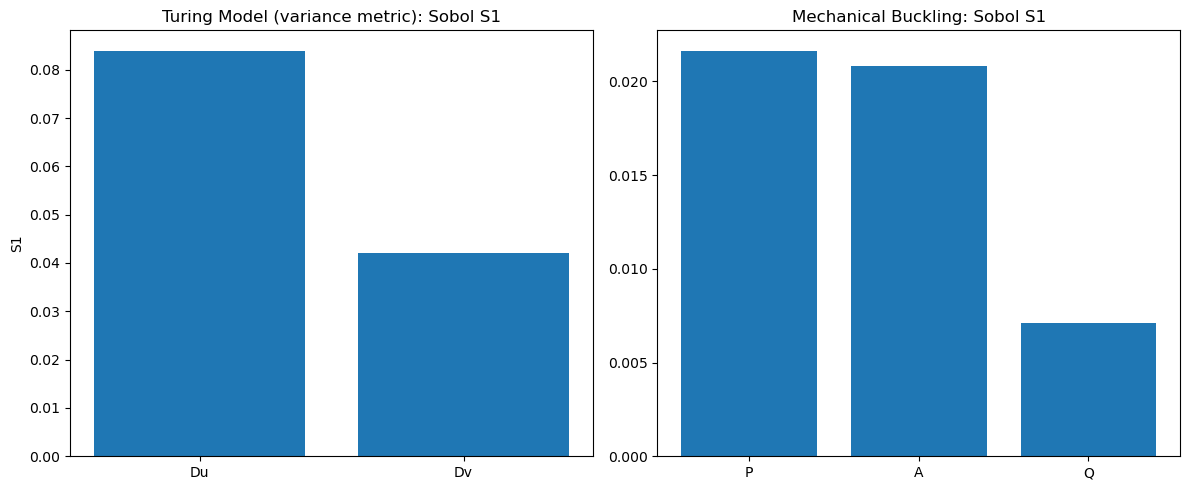

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(problem_turing['names'], np.abs(Si_turing['S1']))
axes[0].set_title('Turing Model (variance metric): Sobol S1')
axes[0].set_ylabel('S1')

axes[1].bar(problem_buckling['names'], np.abs(Si_buckling['S1']))
axes[1].set_title('Mechanical Buckling: Sobol S1')

plt.tight_layout()
plt.show()


In [19]:
problem_turing = {
    'num_vars': 2,
    'names':    ['Du', 'Dv'],
    'bounds':   [[0.05, 0.3], [0.01, 0.1]]
}
N = 32
param_vals = saltelli.sample(problem_turing, N, calc_second_order=False)

Nx = Ny = 32    
dx = 100.0/(Nx-1)
turing_steps = 300

x = np.linspace(0, 100, Nx)
y = np.linspace(0, 100, Ny)
Xgrid, Ygrid = np.meshgrid(x, y)

/var/folders/91/4mn89x6x6rs590bxz0qdh4zc0000gn/T/ipykernel_85152/847248486.py:7: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_vals = saltelli.sample(problem_turing, N, calc_second_order=False)


In [20]:
def process_pair(Du, Dv):
    # Turing simulation
    u0 = np.ones((Nx,Ny)) + 0.02*np.random.randn(Nx,Ny)
    v0 = np.zeros((Nx,Ny)) + 0.02*np.random.randn(Nx,Ny)
    r=4
    u0[Nx//2-r:Nx//2+r,Ny//2-r:Ny//2+r]=0.5
    v0[Nx//2-r:Nx//2+r,Ny//2-r:Ny//2+r]=0.25
    u_sim, v_sim = model.sim_turing(
        Du, Dv,
        lambda u,v: -u*v**2 + 0.035*(1-u),
        lambda u,v:  u*v**2 - (0.035+0.065)*v,
        u0, v0, dx, 1.0, turing_steps
    )
    lam, lam_x, lam_y = model.estimate_wavelength_2d(v_sim, dx)
    var_v = np.var(v_sim)
    anis  = lam_x/lam_y if lam_y else 0.0

    # Buckling on the same coarse grid
    v_norm = (v_sim - v_sim.mean())/v_sim.std()
    tc = 1.0 + 0.3 * v_norm
    q2d = 0.01 * np.random.randn(Ny, Nx)
    w2d = model.sim_buckling_2d(1e5, 0.35, tc, 1e3, q2d, 100.0, 100.0)
    amp = np.ptp(w2d)

    return [Du, Dv, lam, var_v, anis], amp

In [23]:
results = Parallel(n_jobs=-1)(
    delayed(process_pair)(Du, Dv)
    for Du, Dv in param_vals_turing
)

features, Y_amp = zip(*results)
features = np.array(features)
Y_amp     = np.array(Y_amp)

model = PySRRegressor(
    niterations=50,            
    population_size=300,       
    binary_operators=["+", "-", "*", "/"],
    unary_operators=["exp", "log"],
    loss="L1DistLoss()",
    model_selection="best",
    random_state=0,
    procs=4                 
)

model.fit(features, Y_amp)


/Users/jiachen/anaconda3/envs/course_proj/lib/python3.13/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/Users/jiachen/anaconda3/envs/course_proj/lib/python3.13/site-packages/pysr/sr.py:1848: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 8.000e+05
Progress: 426 / 1550 total iterations (27.484%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.804e-03  1.594e+01  y = 0.0039299
4           1.760e-03  8.174e-03  y = 0.0047843 / exp(x₀)
5           1.750e-03  5.960e-03  y = 0.0029656 / (x₀ + 0.54989)
6           1.553e-03  1.197e-01  y = (log(x₃) * -6.3045e-05) + 0.0033229
11          1.525e-03  3.569e-03  y = exp(((log(x₃) * -0.89365) + -9.9707) / x₂) * 0.0040633
13          1.518e-03  2.302e-03  y = exp(((log(x₃) * (x₁ + -0.89365)) + -9.9707) / x₂) * 0....
                                      0040633
15          1.518e-03  6.139e-06  y = exp(((log(x₃) * (-0.89365 + (x₃ + x₁))) + -9.9707) / x...
                                      ₂) * 0.0040633
16          1.517e-03  4.798e-04  

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                        0.003929883   
	1         0.008179                               0.00478171 / exp(x0)   
	2         0.046920                 (0.0001523031 / x0) + 0.0030140714   
	3   >>>>  0.078930            (log(x3) * -6.272431e-5) + 0.0033409747   
	4         0.000500    ((log(x3) * -6.2232466e-5) / x4) + 0.0033597518   
	5         0.016371     exp((-11.275099 - log(x3)) / x2) * 0.004053449   
	6         0.000861  exp(((log(x3) * -0.8904083) + -10.455393) / x2...   
	7         0.002033  exp((-11.297701 - (log(x3) / exp(x1))) / x2) *...   
	8         0.001170  exp(((log(x3) * (x1 + -0.89144206)) + -9.97089...   
	9         0.001166  exp((-11.297701 - (log(x3) / exp(x1 + x1))) / ...   
	10        0.022317  exp((((log(x3 / 0.007040214) / x1) * -0.071941...   
	11        0.006522  exp((((log(x3 / (x0 * x0)) / x1) * -0.08095569...   
	12        0.000306  exp((((log(x3 / (x0 * x0)) * -0.077019006) / x...   
	13        0.000716  exp(((log(x3 / (x0 * x0)) * (-0.069092855 / x1...   
	
	        loss  complexity  
	0   0.001804           1  
	1   0.001760           4  
	2   0.001680           5  
	3   0.001552           6  
	4   0.001551           8  
	5   0.001525           9  
	6   0.001523          11  
	7   0.001520          12  
	8   0.001518          13  
	9   0.001516          14  
	10  0.001483          15  
	11  0.001464          17  
	12  0.001461          23  
	13  0.001455          29  
]

  - outputs/20250504_152714_4mkrr7/hall_of_fame.csv


In [24]:
print(model)  
best = model.equations_.iloc[0]
print(f"Best: y = {best['equation']}  (loss={best['loss']:.4f})")

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                        0.003929883   
	1         0.008179                               0.00478171 / exp(x0)   
	2         0.046920                 (0.0001523031 / x0) + 0.0030140714   
	3   >>>>  0.078930            (log(x3) * -6.272431e-5) + 0.0033409747   
	4         0.000500    ((log(x3) * -6.2232466e-5) / x4) + 0.0033597518   
	5         0.016371     exp((-11.275099 - log(x3)) / x2) * 0.004053449   
	6         0.000861  exp(((log(x3) * -0.8904083) + -10.455393) / x2...   
	7         0.002033  exp((-11.297701 - (log(x3) / exp(x1))) / x2) *...   
	8         0.001170  exp(((log(x3) * (x1 + -0.89144206)) + -9.97089...   
	9         0.001166  exp((-11.297701 - (log(x3) / exp(x1 + x1))) / ...   
	10        0.022317  exp((((log(x3 / 0.007040214) / x1) * -0.071941...   
	11        0.006522  exp((((log(x3 / (x0 * x0)) / x1) * -0.08095569...   
	12      